In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
from datetime import timedelta
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial
from scipy import stats
import pylab
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [3]:
d = h5['sound_data']

# Creating subsample of 10000 points from all four sensors

In [4]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [5]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Reading and graphing data from one sensor

Reading June data from one of the sensors

In [6]:
df = pd.read_csv("sonycnode-b827ebc178d2.sonyc.csv", skiprows = 2, low_memory = False)
df.head()

,timestamp,dBAS
0,1.559362e+09,63.53
1,1.559362e+09,63.73
2,1.559362e+09,64.94
3,1.559362e+09,63.09
4,1.559362e+09,61.66


In [7]:
time_arr = np.empty(df.shape[0], dtype = datetime.datetime)
timestamp_arr = df['timestamp'].values
dBAS_arr = df['dBAS'].values

In [8]:
df.size

5179800

Converts timestamps for each sensor into datetime format

In [10]:
def convert_timestamps(sensor_timestamp):
    """
    Converts a float timestamp to a datetime object.
    
    Parameters
    ----------
    sensor_timestamp : float
        A timestamp in float form.
        
    Returns
    -------
    dt : datetime object
       Datetime object corresponding to the same time as the float timestamp.
    """
    j = sensor_timestamp
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    dt = dt.astimezone(pytz.timezone('US/Eastern'))
    return dt

In [11]:
time_arr = [convert_timestamps(x) for x in timestamp_arr]

Creating a new dataframe with timestamps

In [13]:
time_df = df
time_df['timestamp'] = time_arr
time_df.tail()

,timestamp,dBAS
2589895,2019-07-01 00:00:38.810000-04:00,66.04
2589896,2019-07-01 00:00:39.810000-04:00,69.75
2589897,2019-07-01 00:00:40.810000-04:00,68.68
2589898,2019-07-01 00:00:41.810000-04:00,73.17
2589899,2019-07-01 00:00:42.810000-04:00,77.04


In [ ]:
#take max over minute, mean over minute, median over minute?
#8am to 8pm, 8pm 8am

# Clustering on 45 dimensions

In [14]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

In [15]:
def get_sensor_mask(sensor_name, target_arr):
    """
    Returns a mask to apply on an array of data from different sensors. The mask filters out the data from one sensor.
    
    Parameters
    ----------
    sensor_name : String
        The name of the sensor to retrieve the data for, should take the form of b'sonycnode-[name].sonyc'
    
    target_arr : array of Strings
        Array containing the names of all the sensors.
        
    Returns
    -------
    sensor_mask : boolean array
        A boolean array of the same shape as target_arr, with True values corresponding to the indices containing the
        sensor_name.
    """
    sensor_mask = (target_arr == sensor_name)
    return sensor_mask

In [16]:
def get_time_mask(beginning, end, time_arr):
    interval_mask = (time_arr >= beginning) & (time_arr < end)
    return interval_mask

In [17]:
def get_cluster_assignments(num_clusters, sensor_transformed, fit_arr):
    """
    Returns an array containing the number of each cluster each data point in sensor_transformed is assigned to.
    Clustering is performed using MiniBatchKMeans.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to group sensor_transformed into.
        
    sensor_transformed : array of floats
        45-dimensional array of feature vectors from one sensor 
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
    """
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk.fit(fit_arr)
    cluster_indices = mbk.predict(sensor_transformed)
    return cluster_indices

In [18]:
def convert_to_hour(sensor_timestamp):
    j = sensor_timestamp[i]
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    day = dt.astimezone(pytz.timezone('US/Eastern')).day
    hour = dt.astimezone(pytz.timezone('US/Eastern')).hour
    total_hour = 24*(day-1) + hour
    return total_hour

In [187]:
def plot_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, num_bins, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
    
    num_bins : int
        The number of bins to group the cluster frequency into.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    fig = plt.figure(figsize=(15,100), dpi=60)
    subplot_idx = 1
    y_vals = []

    
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)

    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num)
        
        if(np.sum(cluster_mask) == 0):
            continue
            
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        
        ax1 = fig.add_subplot(num_clusters, 1, subplot_idx)  
        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('truck clusters', color=color)

        if(cluster_num == clusters_plot_arr[0]):
            y, bins, _ = ax1.hist(timestamp_arr, bins=num_bins, color=color)

        ax1.hist(timestamp_arr, bins=bins, color=color)
        y_vals.append(y.max())
        ax1.tick_params(axis='y', labelcolor=color)

    #     print(bins)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
        ax2.plot(spl_time, spl_dBAS_mean, color=color)
        ax2.plot(spl_time, spl_dBAS_max, color='black')
        ax2.plot(spl_time, spl_dBAS_median, color='green')
        ax2.tick_params(axis='y', labelcolor=color)

        subplot_idx += 1 
    #     axes = plt.gca()
        ax1.set_ylim([0,max(y_vals)])
    
    plt.tight_layout()
    plt.show()
#     print(total_timestamp_arr)
    return bins

In [209]:
def plot_truck_clusters(num_clusters, sensor_transformed, fit_arr, sensor_timestamps_dt, spl_time, spl_dBAS_mean, \
                  spl_dBAS_max, spl_dBAS_median, bin_arr, clusters_plot_arr):
    """
    Plots a histogram of the frequency of cluster assignments over time for one sensor.
    
    Parameters
    ----------
    num_clusters : int
        The number of clusters to assign the data to.
        
    sensor_transformed : 45-dimensional array of floats
        An array taken from projected_45 with only the feature vectors corresponding to one sensor.
        
    fit_arr : array of floats
        45-dimensional array of feature vectors from all sensors
        
    sensor_timestamps_dt : datetime array
        Numpy array with dtype=datetime.datetime, containing day values for each data point gathered for a specified
        sensor.
        
    spl_time : datetime array
        Array of datetime objects corresponding to the SPL values.
        
    spl_dBAS_mean : array of floats
        Array of SPL values corresponding to spl_time, averaged over each minute.
        
    spl_dBAS_max : array of floats
        Array of SPL values corresponding to spl_time, consisting of the maximum value from each minute.
        
    spl_dBAS_median : array of floats
        Array of SPL values corresponding to spl_time, consisting of the median value from each minute.
    
    num_bins : int
        The number of bins to group the cluster frequency into.
        
    bin_arr : array of floats
        Array of bin edges to group the cluster frequency into.
        
    clusters_plot_arr : arr of ints within the range(0, num_clusters)
        The indices of the clusters to plot.
    """
    test = get_cluster_assignments(num_clusters, sensor_transformed, fit_arr)
    y_vals = []
    
    total_timestamp_arr = []
    for cluster_num in clusters_plot_arr:
        cluster_mask = np.nonzero(test==cluster_num)
        
        if(np.sum(cluster_mask) == 0):
            continue
            
        timestamp_arr = np.asarray(sensor_timestamps_dt)[cluster_mask]
        for timestamp in timestamp_arr:
            total_timestamp_arr.append(timestamp)
    
#     print(total_timestamp_arr)
    
    fig, ax1 = plt.subplots()  
    color = 'tab:red'
    ax1.set_xlabel('time')
    ax1.set_ylabel('truck clusters', color=color)
        
    y, x, _ = ax1.hist(total_timestamp_arr, bins=bin_arr, color=color)
    y_vals.append(y.max())
    ax1.tick_params(axis='y', labelcolor=color)

#     print(bins)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('dBAS', color=color)  # we already handled the x-label with ax1
    ax2.plot(spl_time, spl_dBAS_mean, color=color)
    ax2.plot(spl_time, spl_dBAS_max, color='black')
    ax2.plot(spl_time, spl_dBAS_median, color='green')
    ax2.tick_params(axis='y', labelcolor=color)

#     axes = plt.gca()
    ax1.set_ylim([0,max(y_vals)])
    
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    fig.show()
#     print(total_timestamp_arr)
#     return bins

In [20]:
b827ebc178d2_mask = get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = [convert_timestamps(x) for x in b827ebc178d2_timestamps]

In [21]:
np.asarray(b827ebc178d2_timestamps_dt, dtype=datetime.datetime).dtype

dtype('O')

In [22]:
b827ebc178d2_timestamps_dt[1]

datetime.datetime(2019, 6, 1, 0, 0, 17, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

# Averaging data

Dataset with one data point every minute

In [23]:
minute_time_arr = np.empty(int(len(time_arr)/60), dtype = datetime.datetime)
minute_dBAS_arr = np.empty(int(len(time_arr)/60))

In [24]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_time_arr[count] = time_arr[i]
    minute_dBAS_arr[count] = np.average(dBAS_arr[i:i+step])
    i += step
    count += 1

# Taking max of data

In [93]:
minute_dBAS_max = np.empty(int(len(time_arr)/60))

In [94]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_max[count] = np.amax(dBAS_arr[i:i+step])
    i += step
    count += 1

In [96]:
minute_dBAS_max

array([73.88, 73.14, 81.78, ..., 74.38, 75.82, 77.04])

# Taking median of data

In [98]:
minute_dBAS_median = np.empty(int(len(time_arr)/60))

In [99]:
step = 60
i = 0
count = 0
while i < len(time_arr): 
    minute_dBAS_median[count] = np.median(dBAS_arr[i:i+step])
    i += step
    count += 1

In [100]:
minute_dBAS_median

array([61.775, 57.79 , 64.23 , ..., 58.02 , 66.055, 61.44 ])

# Plotting 12 hour intervals for one day

Slicing the SPL data

In [25]:
naive_minute_time_arr = [x.replace(tzinfo=None) for x in minute_time_arr]

Slicing for 8am to 8pm

In [26]:
naive_minute_time_arr_np = np.array(naive_minute_time_arr)
minute_time_arr_am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_minute_time_arr_np)

In [102]:
minute_time_arr_am = minute_time_arr[minute_time_arr_am_mask]
minute_dBAS_arr_am = minute_dBAS_arr[minute_time_arr_am_mask]
minute_dBAS_max_am = minute_dBAS_max[minute_time_arr_am_mask]
minute_dBAS_median_am = minute_dBAS_median[minute_time_arr_am_mask]

Slicing for 8pm to 8am

In [28]:
minute_time_arr_pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_minute_time_arr_np)

In [111]:
minute_time_arr_pm = minute_time_arr[minute_time_arr_pm_mask]
minute_dBAS_arr_pm = minute_dBAS_arr[minute_time_arr_pm_mask]
minute_dBAS_max_pm = minute_dBAS_max[minute_time_arr_pm_mask]
minute_dBAS_median_pm = minute_dBAS_median[minute_time_arr_pm_mask]

Slicing the feature vectors from 8am to 8pm

In [30]:
naive_b827ebc178d2_timestamps_dt = [x.replace(tzinfo=None) for x in b827ebc178d2_timestamps_dt]

In [31]:
naive_b827ebc178d2_timestamps_dt_np = np.array(naive_b827ebc178d2_timestamps_dt)
am_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 8), datetime.datetime(2019, 6, 1, 20), naive_b827ebc178d2_timestamps_dt_np)

In [32]:
b827ebc178d2_timestamps_dt_am = np.asarray(b827ebc178d2_timestamps_dt)[am_mask]

Slicing the feature vectors from 8pm to 8am

In [33]:
pm_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 20), datetime.datetime(2019, 6, 2, 8), naive_b827ebc178d2_timestamps_dt_np)

In [34]:
b827ebc178d2_timestamps_dt_pm = np.asarray(b827ebc178d2_timestamps_dt)[pm_mask]

In [35]:
# plot_clusters(15, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
#              minute_time_arr_am, minute_dBAS_arr_am, 12*60)

# Plotting 1 hour intervals

Slicing the SPL data

Slicing for 2pm to 3pm

In [36]:
minute_time_arr_hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_minute_time_arr_np)

In [101]:
minute_time_arr_hour = minute_time_arr[minute_time_arr_hour_mask]
minute_dBAS_arr_hour = minute_dBAS_arr[minute_time_arr_hour_mask]
minute_dBAS_max_hour = minute_dBAS_max[minute_time_arr_hour_mask]
minute_dBAS_median_hour = minute_dBAS_median[minute_time_arr_hour_mask]

Slicing the feature vectors from 2pm to 3pm

In [49]:
hour_mask = \
get_time_mask(datetime.datetime(2019, 6, 1, 14), datetime.datetime(2019, 6, 1, 15), naive_b827ebc178d2_timestamps_dt_np)

In [50]:
b827ebc178d2_timestamps_dt_hour = np.asarray(b827ebc178d2_timestamps_dt)[hour_mask]

# Plotting truck clusters

Truck clusters (in 64 cluster model) are 5, 10, 11, 18, 20, 37, 42, 57, 63

In [45]:
truck_clusters = [5, 10, 11, 18, 20, 37, 42, 57, 63]

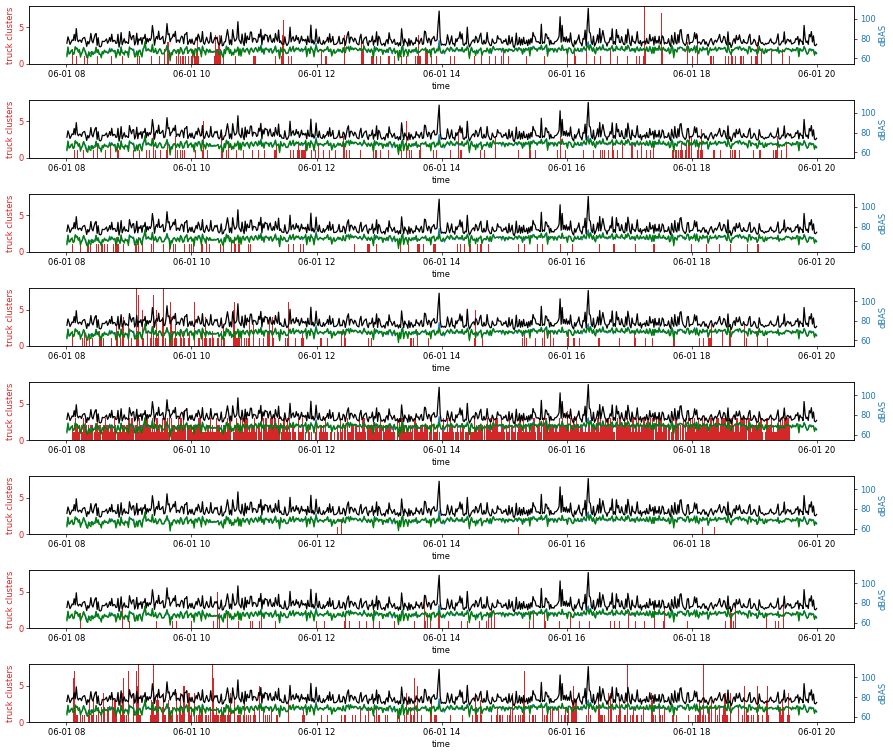

In [194]:
am_bins = plot_clusters(64, b827ebc178d2_transformed[am_mask], projected_45[index], b827ebc178d2_timestamps_dt_am, \
             minute_time_arr_am, minute_dBAS_arr_am, minute_dBAS_max_am, minute_dBAS_median_am, \
              12*60, truck_clusters)

In [216]:
# pm_bins = plot_clusters(64, b827ebc178d2_transformed[pm_mask], projected_45[index], b827ebc178d2_timestamps_dt_pm, \
#              minute_time_arr_pm, minute_dBAS_arr_pm, minute_dBAS_max_pm, minute_dBAS_median_pm, \
#               12*60, truck_clusters)

In [215]:
# hour_bins = plot_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
#                           minute_dBAS_max_hour, minute_dBAS_median_hour, 60, truck_clusters)

In [87]:
#(df['cluster_id']==27).groupby('minute_of_the_day').sum()

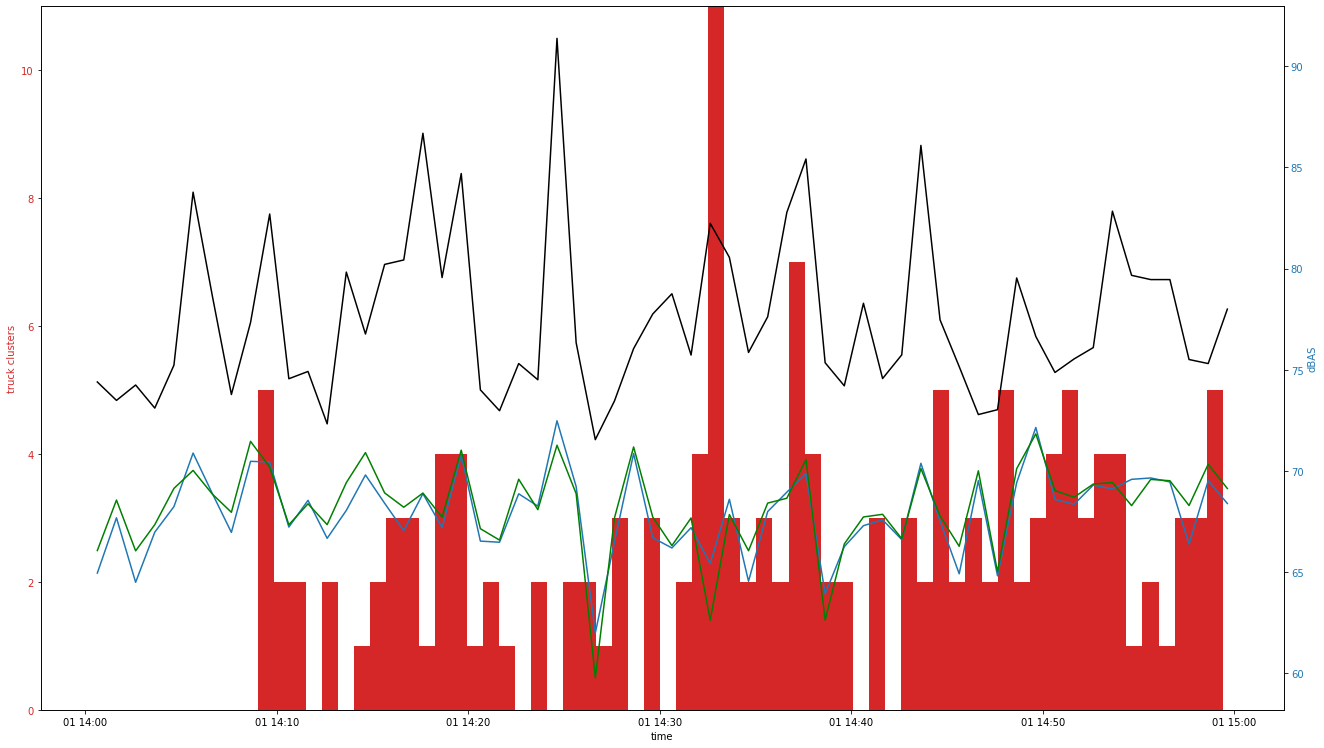

In [210]:
plot_truck_clusters(64, b827ebc178d2_transformed[hour_mask], projected_45[index], \
                          b827ebc178d2_timestamps_dt_hour, minute_time_arr_hour, minute_dBAS_arr_hour, \
                          minute_dBAS_max_hour, minute_dBAS_median_hour, hour_bins, truck_clusters)

In [214]:
# plot_truck_clusters(64, b827ebc178d2_transformed[am_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_am, minute_time_arr_am, minute_dBAS_arr_am, \
#                           minute_dBAS_max_am, minute_dBAS_median_am, am_bins, truck_clusters)

In [213]:
# plot_truck_clusters(64, b827ebc178d2_transformed[pm_mask], projected_45[index], \
#                           b827ebc178d2_timestamps_dt_pm, minute_time_arr_pm, minute_dBAS_arr_pm, \
#                           minute_dBAS_max_pm, minute_dBAS_median_pm, pm_bins, truck_clusters)

In [88]:
#TODO: plot median, max of SPL, aggregate cluster info

In [199]:
len(hour_bins)

61